In [1]:
%load_ext autoreload
%autoreload 2

from datasets import load_dataset
import numpy as np

/Users/leichen/anaconda3/envs/tf_env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
cache_dir = "./data_cache"

train_dataset = load_dataset(
    "tweet_eval",
    name="emotion",
    split="train",
    cache_dir=cache_dir,
)
print(f"Training dataset with {len(train_dataset)} instances loaded")


val_dataset = load_dataset(
    "tweet_eval",
    name="emotion",
    split="validation",
    cache_dir=cache_dir,
)
print(f"Development/validation dataset with {len(val_dataset)} instances loaded")


test_dataset = load_dataset(
    "tweet_eval",
    name="emotion",
    split="test",
    cache_dir=cache_dir,
)
print(f"Test dataset with {len(test_dataset)} instances loaded")

train_texts = train_dataset['text']
train_labels = train_dataset['label']

val_texts = val_dataset['text']
val_labels = val_dataset['label']

test_texts = test_dataset['text']
test_labels = test_dataset['label']

Training dataset with 3257 instances loaded
Development/validation dataset with 374 instances loaded
Test dataset with 1421 instances loaded


In [3]:
from datasets import load_dataset
dataset = load_dataset(
    "tweet_eval", name="emotion"
    )
print("Dataset Structure:", dataset)
print("Training Set Size:", len(dataset['train']))
print("Validation Set Size:", len(dataset['validation']))
print("Test Set Size:", len(dataset['test']))

sample_text = dataset['train'][0]['text']
sample_label = dataset['train'][0]['label']
print("\nSample Text:", sample_text)
print("Sample Label:", sample_label)

from collections import Counter

train_labels = [sample['label'] for sample in dataset['train']]
label_counts = Counter(train_labels)
print("\nLabel Distribution in Training Set:", label_counts)


Dataset Structure: DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 3257
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 1421
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 374
    })
})
Training Set Size: 3257
Validation Set Size: 374
Test Set Size: 1421

Sample Text: “Worry is a down payment on a problem you may never have'.  Joyce Meyer.  #motivation #leadership #worry
Sample Label: 2

Label Distribution in Training Set: Counter({0: 1400, 3: 855, 1: 708, 2: 294})


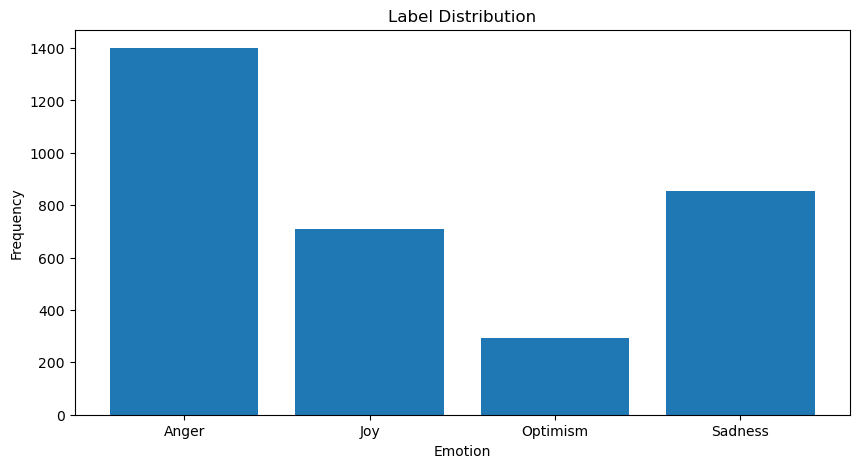

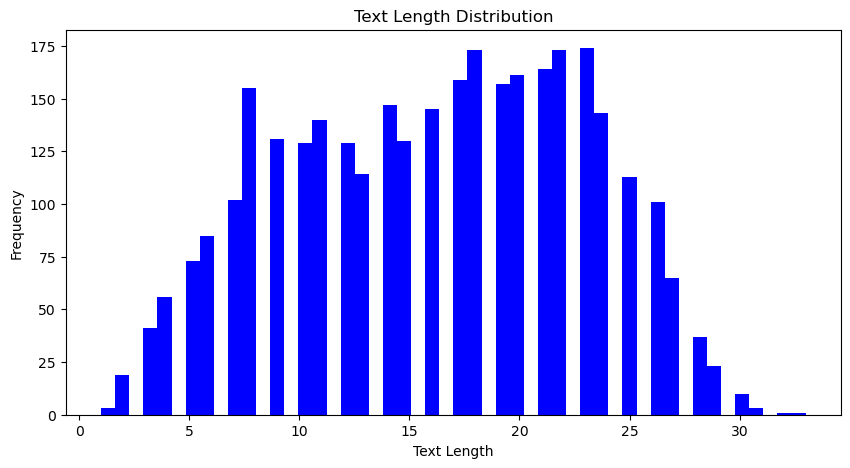

      word  freq
0     user  1010
1     just   124
2     like   118
3      don   114
4   people   101
5    angry    65
6  fucking    57
7      amp    55
8    anger    52
9     rage    47


In [6]:
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd
import numpy as np

train_texts = [example['text'] for example in dataset['train']]
train_labels = [example['label'] for example in dataset['train']]

# Label distribution
plt.figure(figsize=(10, 5))
plt.hist(train_labels, bins=np.arange(-0.5, 4, 1), rwidth=0.8)
plt.title('Label Distribution')
plt.xticks(np.arange(0, 4), ['Anger', 'Joy', 'Optimism', 'Sadness'])
plt.xlabel('Emotion')
plt.ylabel('Frequency')
plt.show()

#Text length analysis
text_lengths = [len(text.split()) for text in train_texts]
plt.figure(figsize=(10, 5))
plt.hist(text_lengths, bins=50, color='blue')
plt.title('Text Length Distribution')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.show()

# High frequency vocabulary analysis (taking Anger as an example)
anger_texts = [text for text, label in zip(train_texts, train_labels) if label == 0]
cv = CountVectorizer(stop_words='english').fit(anger_texts)
word_freq = cv.transform(anger_texts).sum(axis=0)
words_freq = [(word, word_freq[0, idx]) for word, idx in cv.vocabulary_.items()]
words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
df = pd.DataFrame(words_freq, columns=['word', 'freq'])
print(df.head(10))


In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report
import numpy as np
import re
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

def preprocess_text(text):
    text = re.sub(r'\W+', ' ', text) # Remove all non-alphanumeric characters
    text = re.sub(r'\d+', '', text) # Remove all numbers
    text = text.lower() # Convert to lowercase
    tokens = word_tokenize(text)
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    stemmer = PorterStemmer()
    stemmed_tokens = [stemmer.stem(word) for word in tokens]
    return ' '.join(stemmed_tokens)

# TF-IDF
vectorizer = TfidfVectorizer()
X_train_tfidf = vectorizer.fit_transform(train_texts)
X_val_tfidf = vectorizer.transform(val_texts)
X_test_tfidf = vectorizer.transform(test_texts)

y_train = np.array(train_labels)
y_val = np.array(val_labels)
y_test = np.array(test_labels)

# SVM
svm_classifier = SVC(kernel='linear')
svm_classifier.fit(X_train_tfidf, y_train)

y_pred = svm_classifier.predict(X_test_tfidf)
print(classification_report(y_test, y_pred))



[nltk_data] Downloading package punkt to /Users/leichen/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/leichen/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/leichen/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


              precision    recall  f1-score   support

           0       0.62      0.89      0.73       558
           1       0.74      0.53      0.62       358
           2       0.65      0.21      0.32       123
           3       0.71      0.59      0.64       382

    accuracy                           0.66      1421
   macro avg       0.68      0.56      0.58      1421
weighted avg       0.68      0.66      0.64      1421



In [10]:
from imblearn.over_sampling import SMOTE
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
import numpy as np
from datasets import load_dataset

nltk.download('punkt')
nltk.download('stopwords')

def preprocess_text(text):
    text = re.sub(r'\W+', ' ', text) 
    text = re.sub(r'\d+', '', text) 
    text = text.lower() 
    tokens = word_tokenize(text)
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    stemmer = PorterStemmer()
    stemmed_tokens = [stemmer.stem(word) for word in tokens]
    return ' '.join(stemmed_tokens) 

vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(train_texts)
y = np.array(train_labels)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# SMOTE
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X_train, y_train)

svm_classifier = SVC(kernel='linear')
svm_classifier.fit(X_res, y_res)
y_pred = svm_classifier.predict(X_test)
print(classification_report(y_test, y_pred))


[nltk_data] Downloading package punkt to /Users/leichen/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/leichen/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


              precision    recall  f1-score   support

           0       0.67      0.82      0.74       256
           1       0.75      0.60      0.67       165
           2       0.58      0.28      0.38        67
           3       0.60      0.63      0.62       164

    accuracy                           0.66       652
   macro avg       0.65      0.58      0.60       652
weighted avg       0.66      0.66      0.65       652



In [11]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE  

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X_train, y_train)

rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_res, y_res)

y_pred = rf_classifier.predict(X_test)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.52      0.93      0.67       256
           1       0.79      0.34      0.47       165
           2       0.83      0.22      0.35        67
           3       0.73      0.49      0.59       164

    accuracy                           0.60       652
   macro avg       0.72      0.50      0.52       652
weighted avg       0.67      0.60      0.57       652



In [12]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from datasets import load_dataset
import numpy as np


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

vectorizer = TfidfVectorizer(max_features=1000)
X = vectorizer.fit_transform(train_texts)
y = np.array(train_labels)

param_grid = {
    'n_estimators': [50, 100, 200, 300, 400, 500]
}

rf = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X, y)

print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)


Best Parameters: {'n_estimators': 100}
Best Score: 0.6552034152271635


In [14]:
from gensim.models import Word2Vec
from gensim.utils import simple_preprocess

train_corpus = [simple_preprocess(doc) for doc in train_texts]

# Word2Vec
model = Word2Vec(sentences=train_corpus, vector_size=100, window=5, min_count=1, workers=4)
word_vectors = model.wv

import numpy as np

# I've set up a function here to change the text into a Word2Vec vector
def document_vector(word2vec_model, doc):
    # Remove unknown words
    words = [word for word in doc if word in word2vec_model.key_to_index]
    if len(words) >= 1:
        return np.mean(word2vec_model[words], axis=0)
    else:
        return []

X = np.array([document_vector(word_vectors, doc) for doc in train_corpus])

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train, y_train)

y_pred_rf = rf_classifier.predict(X_test)
print(classification_report(y_test, y_pred_rf))

from sklearn.svm import SVC

svm_classifier = SVC(kernel='linear')
svm_classifier.fit(X_train, y_train)

y_pred_svm = svm_classifier.predict(X_test)
print(classification_report(y_test, y_pred_svm))



              precision    recall  f1-score   support

           0       0.42      0.85      0.56       256
           1       0.39      0.10      0.16       165
           2       1.00      0.03      0.06        67
           3       0.33      0.17      0.22       164

    accuracy                           0.40       652
   macro avg       0.53      0.29      0.25       652
weighted avg       0.45      0.40      0.32       652

              precision    recall  f1-score   support

           0       0.39      1.00      0.56       256
           1       0.00      0.00      0.00       165
           2       0.00      0.00      0.00        67
           3       0.00      0.00      0.00       164

    accuracy                           0.39       652
   macro avg       0.10      0.25      0.14       652
weighted avg       0.15      0.39      0.22       652



/Users/leichen/anaconda3/envs/tf_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/leichen/anaconda3/envs/tf_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/leichen/anaconda3/envs/tf_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start,

In [17]:
from collections import Counter

label_distribution = Counter(train_labels)
print("Label distribution:", label_distribution)


Label distribution: Counter({0: 1400, 3: 855, 1: 708, 2: 294})


In [18]:
# Filter for indexes representing joy and optimism.
positive_indices = [i for i, label in enumerate(train_labels) if label in [1, 2]]
positive_texts = [train_texts[i] for i in positive_indices]

print("Number of positive texts (joy and optimism):", len(positive_texts))

# examine
sample_positive_texts = positive_texts[:5]
print("Sample positive texts:", sample_positive_texts)


Number of positive texts (joy and optimism): 1002
Sample positive texts: ["“Worry is a down payment on a problem you may never have'. \xa0Joyce Meyer.  #motivation #leadership #worry", "No but that's so cute. Atsu was probably shy about photos before but cherry helped her out uwu", 'Tiller and breezy should do a collab album. Rapping and singing prolly be fire', "I saved him after ordering him to risk his life. I didn't panic but stayed calm and rescued him.", "@user Uggh that's really horrible. You're not a bad person by any stretch of the imagination. I hope this person realizes that."]


In [20]:
import gensim
from gensim import corpora
from gensim.models import LdaModel
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer

tokenizer = RegexpTokenizer(r'\w+')
stop_words = set(stopwords.words('english'))

def preprocess(text):
    tokens = tokenizer.tokenize(text.lower())
    filtered_tokens = [token for token in tokens if token not in stop_words and token.isalpha()]
    return filtered_tokens

processed_texts = [preprocess(text) for text in positive_texts]

# bag of words model
dictionary = corpora.Dictionary(processed_texts)
corpus = [dictionary.doc2bow(text) for text in processed_texts]

# LDA
lda_model = LdaModel(corpus, num_topics=5, id2word=dictionary, passes=15)
topics = lda_model.print_topics(num_words=4)
for topic in topics:
    print(topic)

import pyLDAvis.gensim_models
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, dictionary)
vis


(0, '0.060*"user" + 0.007*"day" + 0.006*"happy" + 0.005*"like"')
(1, '0.058*"user" + 0.011*"watch" + 0.010*"amazing" + 0.010*"live"')
(2, '0.032*"user" + 0.010*"amp" + 0.006*"know" + 0.005*"get"')
(3, '0.049*"user" + 0.018*"n" + 0.006*"good" + 0.005*"like"')
(4, '0.016*"user" + 0.007*"day" + 0.006*"start" + 0.006*"love"')


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.096830 -0.061452       1        1  24.616544
0      0.027416 -0.017066       2        1  20.948464
2      0.028130  0.129154       3        1  19.702152
3     -0.042357 -0.041171       4        1  19.618962
4     -0.110020 -0.009465       5        1  15.113878, topic_info=          Term       Freq      Total Category  logprob  loglift
105          n  52.000000  52.000000  Default  30.0000  30.0000
393  broadcast  20.000000  20.000000  Default  29.0000  29.0000
395         ly  20.000000  20.000000  Default  28.0000  28.0000
396  musically  20.000000  20.000000  Default  27.0000  27.0000
394       live  25.000000  25.000000  Default  26.0000  26.0000
..         ...        ...        ...      ...      ...      ...
83        want   3.939110  17.749668   Topic5  -5.8699   0.3841
257         go   3.639924  22.027986   Topic5  -5.9489   0.0892
138       well   3.019998  14.189597   Topic5  -6.1356   0.3423
102      every   2.913509  13.459761   Topic5  -6.1715   0.3592
112       good   2.932924  29.096708   Topic5  -6.1649  -0.4051

[354 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
2161      5  0.888025    action
297       4  0.705310  adorable
312       4  0.292467    advice
312       5  0.584933    advice
337       3  0.936174       afl
...     ...       ...       ...
96        1  0.156889     years
96        3  0.156889     years
96        4  0.627557     years
96        5  0.156889     years
1078      3  0.701820       yes

[603 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 1, 3, 4, 5])